In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.cluster import KMeans


In [3]:
# Cargar los DataFrames desde archivos Excel
path_df_location = "../dataset/df_location.xlsx"
df_location = pd.read_excel(path_df_location)

path_df_vehicle = "../dataset/df_vehicle.xlsx"
df_vehicle = pd.read_excel(path_df_vehicle)

path_df_orders = "../dataset/df_orders.xlsx"
df_orders = pd.read_excel(path_df_orders)

path_df_distance_km = "../dataset/df_distance_km.xlsx"
df_distance_km = pd.read_excel(path_df_distance_km)


In [4]:
#print(df_location['Cliente'].unique())
#print(df_orders['cliente'].unique())
#print(df_distance_km.columns)  # Asumiendo que los clientes están como columnas

In [5]:
# Crear Lista de Clientes y Validación
# Lista de clientes más el almacén al inicio y al final
clientes = ['Almacén'] + df_location['Cliente'].tolist() + ['Almacén']

# Validar pedidos individuales antes de asignarlos a vehículos
def validate_clients(orders, vehicles):
    for index, row in orders.iterrows():
        if row['order_demand'] > vehicles['capacidad_kg'].max():
            print(f"El cliente {row['cliente']} tiene una demanda que excede la capacidad de todos los vehículos.")
            return False
    return True

if not validate_clients(df_orders, df_vehicle):
    raise ValueError("Existen pedidos que no pueden ser atendidos por ningún vehículo.")


Definición de Funciones Auxiliares


In [6]:
# Función para calcular el costo de una ruta considerando restricciones de carga y autonomía
def calculate_cost(route, distances, orders, vehicle_capacity, vehicle_range, vehicle_cost_km):
    total_distance = 0
    total_load = 0
    total_cost = 0

    for i in range(len(route) - 1):
        segment_distance = distances.loc[route[i], route[i+1]]

        if segment_distance == 0 or total_distance + segment_distance > vehicle_range:
            return float('inf')  # Ruta no viable por autonomía

        total_distance += segment_distance

        if route[i] != 'Almacén':  # Ignorar el almacén para la carga
            order_row = orders.loc[orders['cliente'] == route[i], 'order_demand']
            if not order_row.empty:
                total_load += order_row.iloc[0]

        if total_load > vehicle_capacity:
            return float('inf')  # Ruta no viable por carga

        total_cost += segment_distance * vehicle_cost_km

    return total_cost

# Función para generar una solución inicial aleatoria
def generate_initial_solution(clientes):
    solution = clientes[:]
    random.shuffle(solution)
    return solution

# Función para obtener vecinos intercambiando dos elementos de la ruta
def get_neighbors(route):
    neighbors = []
    if len(route) > 2:  # Asegura que hay más de un cliente además del almacén
        for i in range(1, len(route)-1):
            for j in range(i + 1, len(route)-1):
                new_route = route[:]
                new_route[i], new_route[j] = new_route[j], new_route[i]
                neighbors.append(new_route)
    return neighbors if neighbors else [route]  # Retorna la ruta actual si no hay vecinos

# Función principal del algoritmo Hill Climbing
def hill_climbing(clientes, distances, orders, vehicle_capacity, vehicle_range, vehicle_cost_km):
    current_solution = generate_initial_solution(clientes)
    current_cost = calculate_cost(current_solution, distances, orders, vehicle_capacity, vehicle_range, vehicle_cost_km)
    
    while True:
        neighbors = get_neighbors(current_solution)
        if not neighbors:
            print("No hay vecinos posibles, terminando la optimización.")
            break
        
        next_solution = min(neighbors, key=lambda r: calculate_cost(r, distances, orders, vehicle_capacity, vehicle_range, vehicle_cost_km))
        next_cost = calculate_cost(next_solution, distances, orders, vehicle_capacity, vehicle_range, vehicle_cost_km)
        
        if next_cost >= current_cost:
            break
        
        current_solution, current_cost = next_solution, next_cost
    
    return current_solution, current_cost




In [7]:
# Calcular el costo total de todas las subrutas de un vehículo
def calculate_total_cost(subroutes, distances, vehicle_cost_km):
    total_cost = 0
    for subroute in subroutes:
        subroute_cost = 0
        for i in range(len(subroute) - 1):
            segment_distance = distances.loc[subroute[i], subroute[i + 1]]
            if segment_distance == 0.0:  # Conexión inválida
                print(f"Error: Distancia inválida entre {subroute[i]} y {subroute[i + 1]}.")
                return float('inf')  # Ruta inválida
            subroute_cost += segment_distance * vehicle_cost_km
        total_cost += subroute_cost
    return total_cost


In [8]:
# Dividir rutas basadas en restricciones de capacidad y autonomía
def split_route_by_constraints(route, distances, orders, vehicle_capacity, vehicle_range):
    subroutes = []
    current_subroute = ['Almacén']
    current_load = 0
    current_distance = 0

    for cliente in route:
        if cliente == 'Almacén':
            continue  # Ignorar el almacén dentro de la lógica
        order_demand = orders.loc[orders['cliente'] == cliente, 'order_demand'].iloc[0]
        last_stop = current_subroute[-1]
        segment_distance = distances.loc[last_stop, cliente]

        # Verificar si se exceden las restricciones de carga o autonomía
        if (current_load + order_demand > vehicle_capacity or
                current_distance + segment_distance > vehicle_range):
            # Cierra la subruta y empieza una nueva
            current_subroute.append('Almacén')
            subroutes.append(current_subroute)
            current_subroute = ['Almacén', cliente]
            current_load = order_demand
            current_distance = distances.loc['Almacén', cliente]
        else:
            current_subroute.append(cliente)
            current_load += order_demand
            current_distance += segment_distance

    # Asegurarse de cerrar la última subruta
    if current_subroute[-1] != 'Almacén':
        current_subroute.append('Almacén')
    subroutes.append(current_subroute)

    return subroutes


# Corregir subrutas con conexiones inválidas
def correct_invalid_subroutes(subroute, distances):
    corrected_subroutes = []
    current_subroute = ['Almacén']
    
    for i in range(1, len(subroute)):
        segment_distance = distances.loc[subroute[i - 1], subroute[i]]
        
        if segment_distance == 0.0:  # Conexión inválida
            print(f"Error: Distancia inválida entre {subroute[i - 1]} y {subroute[i]}. Dividiendo la subruta.")
            current_subroute.append('Almacén')
            corrected_subroutes.append(current_subroute)
            current_subroute = ['Almacén', subroute[i]]
        else:
            current_subroute.append(subroute[i])
    
    # Asegurarse de cerrar la última subruta
    if current_subroute[-1] != 'Almacén':
        current_subroute.append('Almacén')
    corrected_subroutes.append(current_subroute)
    
    return corrected_subroutes




In [9]:
# Agrupamiento de clientes usando K-Means
num_vehicles = len(df_vehicle)
kmeans = KMeans(n_clusters=num_vehicles, random_state=42, n_init=10)
df_location['cluster'] = kmeans.fit_predict(df_location[['Latitud', 'Longitud']])

vehicle_routes = {}
vehicle_costs = {}

for vehicle_id in range(num_vehicles):
    cluster_customers = df_location[df_location['cluster'] == vehicle_id]['Cliente'].tolist() + ['Almacén']
    vehicle_capacity = df_vehicle.iloc[vehicle_id]['capacidad_kg']
    vehicle_range = df_vehicle.iloc[vehicle_id]['autonomia_km']
    vehicle_cost_km = df_vehicle.iloc[vehicle_id]['costo_km']

    # Optimización inicial de la ruta
    optimal_route, _ = hill_climbing(
        cluster_customers,
        df_distance_km.set_index('CLIENTES'),
        df_orders,
        vehicle_capacity,
        vehicle_range,
        vehicle_cost_km
    )

    # Corregir conexiones inválidas
    corrected_subroutes = correct_invalid_subroutes(
        optimal_route,
        df_distance_km.set_index('CLIENTES')
    )

    # Dividir cada subruta por restricciones
    final_subroutes = []
    for subroute in corrected_subroutes:
        final_subroutes.extend(
            split_route_by_constraints(
                subroute,
                df_distance_km.set_index('CLIENTES'),
                df_orders,
                vehicle_capacity,
                vehicle_range
            )
        )

    # Calcular el costo total de las subrutas finales
    total_cost = calculate_total_cost(final_subroutes, df_distance_km.set_index('CLIENTES'), vehicle_cost_km)

    vehicle_routes[vehicle_id] = final_subroutes
    vehicle_costs[vehicle_id] = total_cost





Error: Distancia inválida entre Cliente_7 y Cliente_13. Dividiendo la subruta.


In [10]:
# Identificar clientes no atendidos
entregados = set(client for routes in vehicle_routes.values() for subroute in routes for client in subroute if client != 'Almacén')
clientes_no_atendidos = set(df_orders['cliente']) - entregados

if clientes_no_atendidos:
    print(f"Clientes no atendidos: {clientes_no_atendidos}")
    
    # Redistribuir clientes no atendidos
    for cliente in clientes_no_atendidos:
        reasignado = False
        for vehicle_id, routes in vehicle_routes.items():
            # Verificar capacidad y autonomía disponibles
            vehicle_capacity = df_vehicle.iloc[vehicle_id]['capacidad_kg']
            vehicle_range = df_vehicle.iloc[vehicle_id]['autonomia_km']
            vehicle_cost_km = df_vehicle.iloc[vehicle_id]['costo_km']
            distances = df_distance_km.set_index('CLIENTES')
            
            # Verificar si el cliente puede ser agregado a alguna subruta existente
            for subroute in routes:
                subroute_cost = calculate_cost(
                    subroute + [cliente, 'Almacén'], distances, df_orders, vehicle_capacity, vehicle_range, vehicle_cost_km
                )
                if subroute_cost < float('inf'):
                    print(f"Reasignando {cliente} al Vehículo {vehicle_id + 1} en subruta existente.")
                    subroute.insert(-1, cliente)  # Insertar el cliente antes del 'Almacén'
                    reasignado = True
                    break
            
            # Si no se reasignó a una subruta existente, crear una nueva subruta
            if not reasignado:
                print(f"Creando nueva subruta para {cliente} en Vehículo {vehicle_id + 1}.")
                vehicle_routes[vehicle_id].append(['Almacén', cliente, 'Almacén'])
                reasignado = True
            
            if reasignado:
                break


Clientes no atendidos: {'Cliente_19', 'Cliente_10'}
Creando nueva subruta para Cliente_19 en Vehículo 1.
Reasignando Cliente_10 al Vehículo 1 en subruta existente.


In [11]:
print(vehicle_routes)
print(vehicle_costs)	

{0: [['Almacén', 'Cliente_12', 'Cliente_18', 'Almacén'], ['Almacén', 'Cliente_19', 'Cliente_10', 'Almacén']], 1: [['Almacén', 'Cliente_14', 'Cliente_11', 'Cliente_4', 'Cliente_5', 'Almacén'], ['Almacén', 'Cliente_1', 'Cliente_17', 'Cliente_6', 'Cliente_16', 'Almacén'], ['Almacén', 'Cliente_9', 'Almacén']], 2: [['Almacén', 'Cliente_20', 'Almacén']], 3: [['Almacén', 'Cliente_7', 'Almacén'], ['Almacén', 'Cliente_13', 'Cliente_3', 'Cliente_2', 'Almacén']], 4: [['Almacén', 'Cliente_8', 'Cliente_15', 'Almacén']], 5: [['Almacén']]}
{0: np.float64(5.730899999999999), 1: np.float64(7.316428), 2: np.float64(5.931280000000001), 3: np.float64(9.305592), 4: np.float64(13.584928), 5: 0}


In [12]:
# Identificar vehículos con costos infinitos
problematic_vehicles = [vehicle_id for vehicle_id, cost in vehicle_costs.items() if cost == float('inf')]

# Mostrar cuáles vehículos tienen costos infinitos
if problematic_vehicles:
    print(f"Vehículos con costos infinitos: {[v + 1 for v in problematic_vehicles]}")
else:
    print("No hay vehículos con costos infinitos.")


No hay vehículos con costos infinitos.


In [13]:
# Asegurar que todos los vehículos realicen al menos una entrega
vehicles_without_deliveries = [vid for vid, cost in vehicle_costs.items() if cost == 0]
if vehicles_without_deliveries:
    print(f"Vehículos sin entregas significativas: {[v + 1 for v in vehicles_without_deliveries]}")
    
    for vehicle_id in vehicles_without_deliveries:
        for other_vehicle_id in vehicle_routes:
            if other_vehicle_id != vehicle_id:
                for subroute in vehicle_routes[other_vehicle_id]:
                    for client in subroute:
                        if client != 'Almacén':  # Evitar el almacén
                            print(f"Reasignando {client} al Vehículo {vehicle_id + 1}.")
                            
                            # Crear una nueva subruta para el cliente reasignado
                            vehicle_routes[vehicle_id] = [['Almacén', client, 'Almacén']]
                            
                            # Eliminar cliente de la subruta original
                            subroute.remove(client)
                            
                            # Si la subruta queda vacía, eliminarla
                            if len(subroute) <= 2:
                                vehicle_routes[other_vehicle_id].remove(subroute)
                            
                            # Recalcular el costo para el vehículo
                            vehicle_cost_km = df_vehicle.iloc[vehicle_id]['costo_km']
                            distances = df_distance_km.set_index('CLIENTES')
                            vehicle_costs[vehicle_id] = calculate_total_cost(vehicle_routes[vehicle_id], distances, vehicle_cost_km)
                            break
                    if vehicle_costs[vehicle_id] > 0:
                        break
            if vehicle_costs[vehicle_id] > 0:
                break



Vehículos sin entregas significativas: [6]
Reasignando Cliente_12 al Vehículo 6.


In [14]:
# Corregir subrutas con costos infinitos
problematic_vehicles = [vehicle_id for vehicle_id, cost in vehicle_costs.items() if cost == float('inf')]
for vehicle_id in problematic_vehicles:
    print(f"Corrigiendo subrutas para el Vehículo {vehicle_id + 1}...")
    
    corrected_subroutes = []
    distances = df_distance_km.set_index('CLIENTES')
    vehicle_capacity = df_vehicle.iloc[vehicle_id]['capacidad_kg']
    vehicle_range = df_vehicle.iloc[vehicle_id]['autonomia_km']

    for subroute in vehicle_routes[vehicle_id]:
        corrected_subroutes.extend(
            split_route_by_constraints(
                subroute,
                distances,
                df_orders,
                vehicle_capacity,
                vehicle_range
            )
        )

    # Actualizar las subrutas corregidas para el vehículo
    vehicle_routes[vehicle_id] = corrected_subroutes

    # Recalcular el costo total para las subrutas corregidas
    vehicle_cost_km = df_vehicle.iloc[vehicle_id]['costo_km']
    total_cost = calculate_total_cost(corrected_subroutes, distances, vehicle_cost_km)
    vehicle_costs[vehicle_id] = total_cost

    print(f"Subrutas Corregidas para el Vehículo {vehicle_id + 1}:")
    for idx, subroute in enumerate(corrected_subroutes, 1):
        print(f"  Subruta {idx}: {' -> '.join(subroute)}")
    print(f"Costo Total Corregido: {total_cost}")



In [15]:
# Mostrar las rutas óptimas y los costos mínimos para cada vehículo
for vehicle_id in vehicle_routes:
    print(f"Vehículo {vehicle_id + 1}:")
    for idx, subroute in enumerate(vehicle_routes[vehicle_id], 1):
        print(f"  Subruta {idx}: {' -> '.join(subroute)}")
    print("Costo Total:", vehicle_costs[vehicle_id])
    print("\n")


Vehículo 1:
  Subruta 1: Almacén -> Cliente_18 -> Almacén
  Subruta 2: Almacén -> Cliente_19 -> Cliente_10 -> Almacén
Costo Total: 5.730899999999999


Vehículo 2:
  Subruta 1: Almacén -> Cliente_14 -> Cliente_11 -> Cliente_4 -> Cliente_5 -> Almacén
  Subruta 2: Almacén -> Cliente_1 -> Cliente_17 -> Cliente_6 -> Cliente_16 -> Almacén
  Subruta 3: Almacén -> Cliente_9 -> Almacén
Costo Total: 7.316428


Vehículo 3:
  Subruta 1: Almacén -> Cliente_20 -> Almacén
Costo Total: 5.931280000000001


Vehículo 4:
  Subruta 1: Almacén -> Cliente_7 -> Almacén
  Subruta 2: Almacén -> Cliente_13 -> Cliente_3 -> Cliente_2 -> Almacén
Costo Total: 9.305592


Vehículo 5:
  Subruta 1: Almacén -> Cliente_8 -> Cliente_15 -> Almacén
Costo Total: 13.584928


Vehículo 6:
  Subruta 1: Almacén -> Cliente_12 -> Almacén
Costo Total: 2.866472




In [16]:
# Validar que todos los clientes están cubiertos
entregados = set(client for routes in vehicle_routes.values() for subroute in routes for client in subroute if client != 'Almacén')
clientes_pendientes = set(df_orders['cliente']) - entregados

if clientes_pendientes:
    print(f"Clientes no atendidos: {clientes_pendientes}")
else:
    print("Todos los clientes están atendidos.")

# Validar restricciones de capacidad y autonomía
for vehicle_id, routes in vehicle_routes.items():
    vehicle_capacity = df_vehicle.iloc[vehicle_id]['capacidad_kg']
    vehicle_range = df_vehicle.iloc[vehicle_id]['autonomia_km']
    distances = df_distance_km.set_index('CLIENTES')
    
    for subroute in routes:
        carga_total = sum(df_orders.loc[df_orders['cliente'] == client, 'order_demand'].iloc[0] for client in subroute if client != 'Almacén')
        distancia_total = sum(distances.loc[subroute[i], subroute[i+1]] for i in range(len(subroute)-1))
        
        if carga_total > vehicle_capacity:
            print(f"Advertencia: El Vehículo {vehicle_id + 1} excede su capacidad en la subruta {subroute}.")
        if distancia_total > vehicle_range:
            print(f"Advertencia: El Vehículo {vehicle_id + 1} excede su autonomía en la subruta {subroute}.")


Todos los clientes están atendidos.


Representación Gráfica

In [17]:
import matplotlib.pyplot as plt

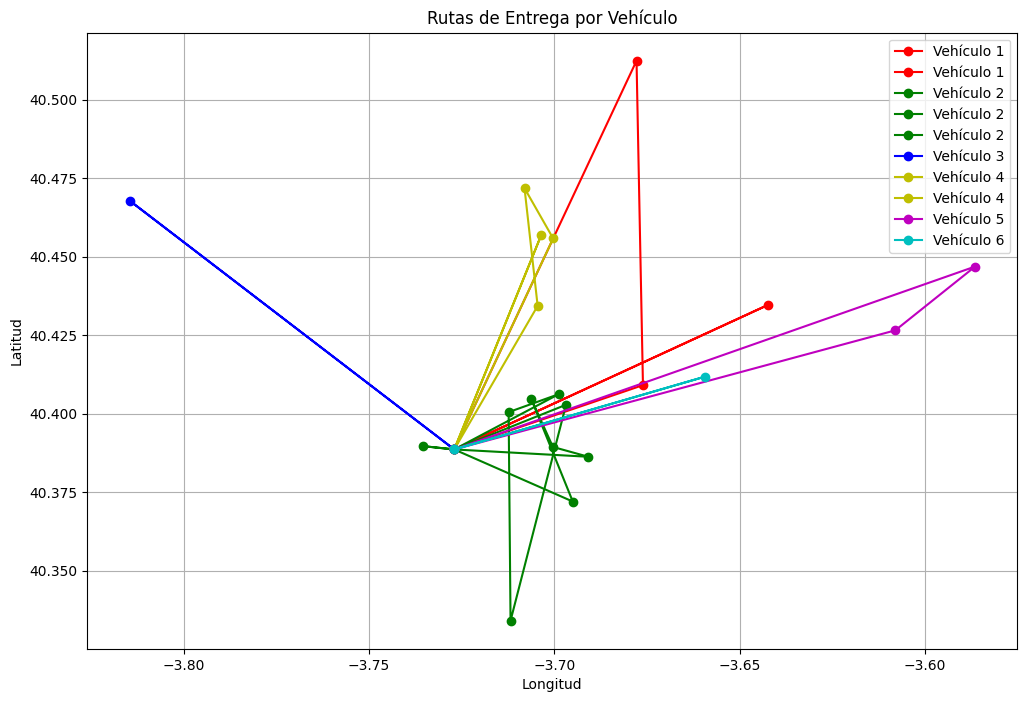

In [18]:
# Crear representación gráfica de las rutas
def plot_routes(vehicle_routes, df_location):
    plt.figure(figsize=(12, 8))
    colors = ['r', 'g', 'b', 'y', 'm', 'c', 'orange', 'purple']

    # Dibujar las rutas de cada vehículo
    for vehicle_id, routes in vehicle_routes.items():
        for subroute in routes:
            x_coords = [df_location[df_location['Cliente'] == client]['Longitud'].iloc[0] for client in subroute if client != 'Almacén']
            y_coords = [df_location[df_location['Cliente'] == client]['Latitud'].iloc[0] for client in subroute if client != 'Almacén']
            
            # Agregar las coordenadas del almacén
            x_coords = [df_location[df_location['Cliente'] == 'Almacén']['Longitud'].iloc[0]] + x_coords + [df_location[df_location['Cliente'] == 'Almacén']['Longitud'].iloc[0]]
            y_coords = [df_location[df_location['Cliente'] == 'Almacén']['Latitud'].iloc[0]] + y_coords + [df_location[df_location['Cliente'] == 'Almacén']['Latitud'].iloc[0]]
            
            plt.plot(x_coords, y_coords, marker='o', label=f'Vehículo {vehicle_id + 1}', color=colors[vehicle_id % len(colors)])
    
    # Añadir detalles al gráfico
    plt.title("Rutas de Entrega por Vehículo")
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.legend()
    plt.grid(True)
    plt.show()

# Llamar a la función para graficar
plot_routes(vehicle_routes, df_location)


Código para Generar Mapas

In [21]:
import folium

In [24]:
#Generar Mapas Interactivos	
def generate_route_map(vehicle_routes, df_location):
    # Crear un mapa centrado en la ubicación del almacén
    almacen_coords = df_location[df_location['Cliente'] == 'Almacén'][['Latitud', 'Longitud']].iloc[0]
    route_map = folium.Map(location=[almacen_coords['Latitud'], almacen_coords['Longitud']], zoom_start=12)

    # Colores para las rutas de los vehículos
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'darkblue', 'darkgreen']
    
    # Dibujar rutas para cada vehículo
    for vehicle_id, routes in vehicle_routes.items():
        color = colors[vehicle_id % len(colors)]
        for subroute in routes:
            # Coordenadas de los clientes en la subruta
            subroute_coords = [
                (df_location[df_location['Cliente'] == client]['Latitud'].iloc[0], 
                 df_location[df_location['Cliente'] == client]['Longitud'].iloc[0])
                for client in subroute
            ]
            # Añadir la subruta al mapa
            folium.PolyLine(subroute_coords, color=color, weight=5, opacity=0.8).add_to(route_map)
            
            # Añadir marcadores para cada cliente en la subruta
            for client in subroute:
                client_coords = df_location[df_location['Cliente'] == client][['Latitud', 'Longitud']].iloc[0]
                folium.Marker(
                    location=[client_coords['Latitud'], client_coords['Longitud']],
                    popup=f'{client} (Vehículo {vehicle_id + 1})',
                    icon=folium.Icon(color=color)
                ).add_to(route_map)
    
    # Guardar el mapa en un archivo HTML
    route_map.save("mapa_rutas_hill_climbing.html")
    print("Mapa generado y guardado como 'mapa_rutas_hill_climbing.html'.")

# Generar el mapa
generate_route_map(vehicle_routes, df_location)


Mapa generado y guardado como 'mapa_rutas_hill_climbing.html'.
